In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import enum
import copy
import connect4.connect4 as game
from pympler import asizeof
import deeplearning.buffer as buf
import torch 
import torch.nn as nn
import torch.optim as optim
import deeplearning.mlp as mlp
import torch.nn.functional as F
from deeplearning.league import League
import matplotlib.pyplot as plt

In [2]:
lea = League()

In [3]:
while True:
    lea.play_season()

Season 0 training new Agent
100 194.41815435886383 87 1.9414554
200 193.92848312854767 198 1.9349009
300 193.45556724071503 273 1.9315858
400 193.0421417951584 386 1.9262503
500 192.57688403129578 492 1.9178703


In [21]:
lea.elo_history

{0: [883.0, 874.0, 860.0],
 1: [1048.0, 1025.0, 1010.0],
 2: [1069.0, 1069.0, 1062.0],
 3: [0, 1032.0, 1050.0],
 4: [0, 0, 1018.0]}

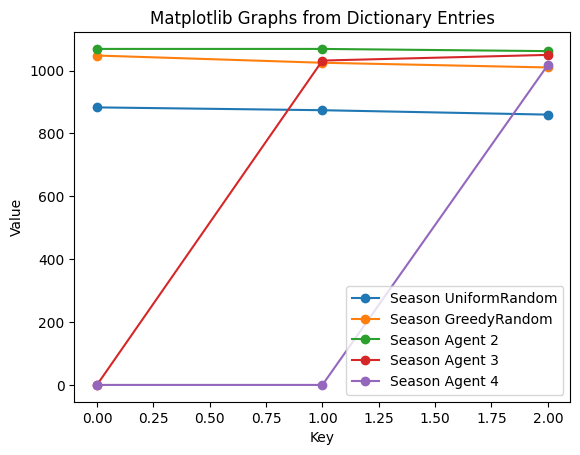

In [22]:
import matplotlib.pyplot as plt

data = lea.elo_history

# Iterate through the dictionary entries and create separate plots
for key, values in data.items():
    name = f'Agent {key-2}'
    if key == 0:
        name = f'UniformRandom'
    elif key == 1:
        name = f'GreedyRandom'
    plt.plot([x for x in range(0, len(values))], values, marker='o', label=f'Season {name}')

# Add labels and title
plt.xlabel('Key')
plt.ylabel('Value')
plt.title('Matplotlib Graphs from Dictionary Entries')
plt.legend()  # Add legend to differentiate between entries

# Show the plots
plt.show()